# Generating Masks for VST fields

## This notebook aims to automatically generate a mask for a photometric VST field according to the 'radial' criteria

### Previous procedure done:
- Using the r band image (more spurious objects) and selecting visually the ghost generated by the brightest stars
- Matching our catalog with GAIA to obtain the true RA, DEC of these stars and reject false stars
-

### Procedure done in this notebook:
- INPUT: handmade ghosts, catalog of bright stars and VST field 
- Finding the effective center of the field in pixels 
- Step 1: finding a linear relation for the distance 'star-handmade ghost' as a function of the distance 'star-center of the field'
- Step 2: verifying that the angle 'star-center of the field' corresponds to the angle 'handmade ghost-center of the field'
- Step 3: finding a simple relation for the handmade ghost radius as a function of the star magnitude
- Voilà... now putting togheter the distance relation, the angle and the radius you can generate an 'automatic' mask using only RA, DEC and MAG_AUTO of the brightest stars and compare it with the handmade mask

### Working on:
- OUTPUT: Generate a .fits immage with the same dimensions as the original but containing only the mask 

### Future improvements:
- Adding the stars halo and spikes (few sorgents according to SExtractor)
- Testing the validity of the procedure for the other bands
- Determine the level of 'spuriousness' of the sources into the ghosts (final goal of the mask)
- 'Pipeline': once that the mask is calibrated, implement an easy way to mask other fields, skiping the handmade ghost section and using only the VST image and RA, DEC and MAG_AUTO of the brightest stars from GAIA 

### Manual steps done (working on finding an automatic way): 
- spot fake stars on the BIG_STARS catalogue -> will be solved by matching our catalog with GAIA 
- ordering the regions file with the catalogue (this was a really ugly thing that I've done... never again!)


# Importing libraries

In [1]:
import time
import logging
import pyregion
import numpy as np
from   numpy import linalg
from   astropy import wcs
from   astropy.io import fits
from   matplotlib import rcParams
from   matplotlib.path import Path
from   matplotlib import pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
rcParams["font.size"] = 18

# Loading data 
All the paths to files loaded are here, if you're using this notebook from another computer, you just have to change this cell

In [4]:
#handmadeghosts  = 'https://raw.githubusercontent.com/nicostrada/photo_mask/master/data/Handmade_ghosts_m0416.reg'
handmadeghosts   = 'regions/Handmade_ghosts_m0416.reg'
handmadehalos    = 'regions/Handmade_halos_m0416.reg'

#stars            = 'https://raw.githubusercontent.com/nicostrada/photo_mask/master/data/M0416_rband_BIGSTARS2_header.cat'
stars            = 'regions/M0416_rband_BIGSTARS2_header.cat'
stars_gaia       = 'regions/GAIA_VST_BIGSTARS.cat'



# This file is not online because it's 3.6 GB!
image           = '/users/nestrada/Documents/Game/VST_GAME/M0416/rband/images/game_macsj0416_omegacam_sdss_r_20190614_g2sw.fits'

# Obtaining the effective center of the field

In [5]:
with fits.open(image) as hdulist:
    hdulist.info()
    data = hdulist[0].data
    hdu  = hdulist[0]
    w = wcs.WCS(hdulist[0].header)

n1  = hdu.header['NAXIS1']
n2  = hdu.header['NAXIS2']

# Finding the effective dimensions of the image
for i in range(n1):
    if data[i,:].min() != 0:
        y_min = i 
        break
for i in range(y_min,n1):
    if data[i,:].min() == 0:
        y_max = i 
        break
for i in range(n1):
    if data[:,i].min() != 0:
        x_min = i 
        break
for i in range(x_min,n1):
    if data[:,i].min() == 0:
        x_max = i 
        break
print(x_min, y_min)
print(x_max, y_max)

# Effective central x pixel of the field
xc = np.floor((x_min+x_max)/2).astype(int)

# Effective central y pixel of the field
yc = np.floor((y_min+y_max)/2).astype(int)

print(xc,yc)

# One last step hand-made :(
# ID of fake stars in the catalog
fake_id = [58829,91745,94077,133181,148524,170232,164123] 

real_fake = [58829,91745] 
ignored_stars = [94077,133181,148524,170232,164123]

Filename: /users/nestrada/Documents/Game/VST_GAME/M0416/rband/images/game_macsj0416_omegacam_sdss_r_20190614_g2sw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     446   (30000, 30000)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


6966 4610
25848 24507
16407 14558


# Seting XY for the ghosts and stars

In [7]:
# Loading the HANDMADE ghosts! 
ghosts = pyregion.open(handmadeghosts)
xg = []
yg = []
rg = []
for i in range(len(ghosts)):
    xg.append(ghosts[i].coord_list[0])
    yg.append(ghosts[i].coord_list[1])
    rg.append(ghosts[i].coord_list[2])
    
# X coordinate of the HANDMADE ghosts
xg = np.array(xg)
# Y coordinate of the HANDMADE ghosts
yg = np.array(yg)
# Radius of the HANDMADE ghosts
rg = np.array(rg)

print(len(xg))

# Loading the HANDMADE halos! 
halos = pyregion.open(handmadehalos)
xh = []
yh = []
rh = []
for i in range(len(halos)):
    xh.append(halos[i].coord_list[0])
    yh.append(halos[i].coord_list[1])
    rh.append(halos[i].coord_list[2])
    
# X coordinate of the HANDMADE ghosts
xh = np.array(xh)
# Y coordinate of the HANDMADE ghosts
yh = np.array(yh)
# Radius of the HANDMADE ghosts
rh = np.array(rh)
print(len(xh))

# Excluding fake stars from the catalog
big_stars = np.loadtxt(stars)


# Excluding stars with no handmade ghosts
fake_mask = np.isin(big_stars[:,0],fake_id,invert=True) 
stars_true = big_stars[fake_mask]                            

# Calling the X, Y and MAG_AUTO of stars from our catalog - See Apendix for the header of the catalog
id_star = stars_true[:,0]
xs = stars_true[:,5]
ys = stars_true[:,6]
mags= stars_true[:,7]

print(len(xs))

27
27
27


24
0.8143708687697171 1.0916193281280615


(7.0, 12.0)

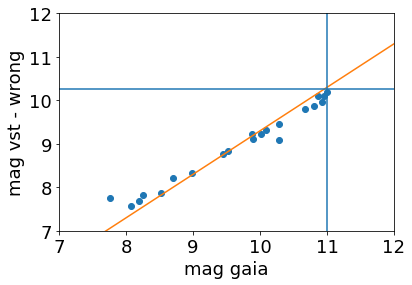

In [45]:
# Calling the X, Y and MAG_AUTO of GAIA

big_stars_gaia = np.loadtxt(stars_gaia)
ra_gaia        = big_stars_gaia[:,1]
dec_gaia       = big_stars_gaia[:,2]
mags_gaia      = big_stars_gaia[:,3]
mags_ours_gaia = big_stars_gaia[:,7]

world   = np.array([ra_gaia,dec_gaia]).T
pixcrd2 = w.wcs_world2pix(world, 0)

xs_gaia = pixcrd2[:,0]
ys_gaia = pixcrd2[:,1]

print(len(xs_gaia))
AAA    = np.vstack([mags_gaia[mags_ours_gaia<11], np.ones(len(mags_gaia[mags_ours_gaia<11]))]).T
mmm, ccc = np.linalg.lstsq(AAA,mags_ours_gaia[mags_ours_gaia<11],rcond=None)[0]

print(mmm,ccc)
plt.plot(mags_gaia,mags_ours_gaia,'o')
#plt.plot(np.linspace(0,20,20),mmm*np.linspace(0,20,20)+ccc)
plt.plot(np.linspace(0,20,20),np.linspace(0,20,20)-0.7)
plt.axvline(11)
plt.axhline(11-0.75)
plt.xlabel('mag gaia')
plt.ylabel('mag vst - wrong')
plt.ylim(7,12)
plt.xlim(7,12)

# Input plot

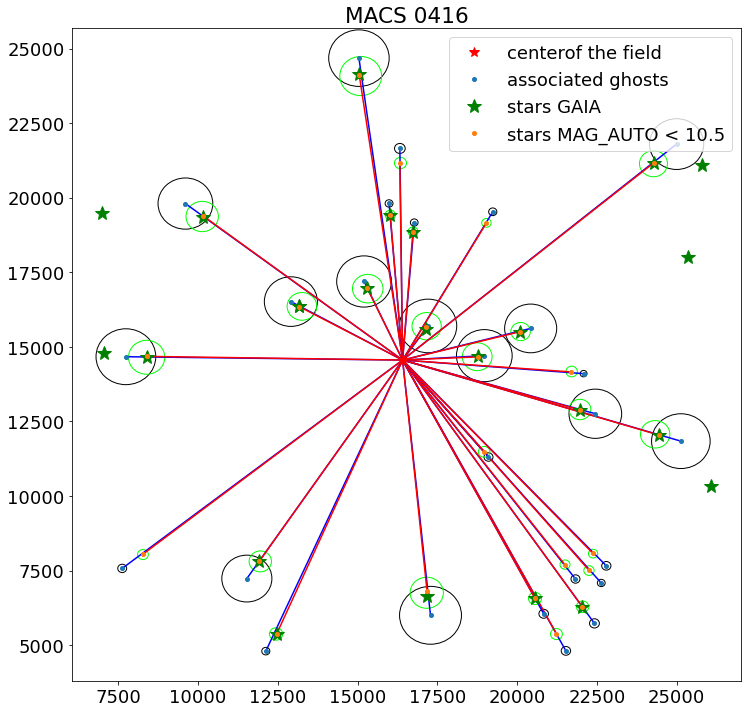

16407 14558


In [5]:
plt.figure(figsize=(12,12))
fig = plt.gcf()
ax  = fig.gca()

for i in range(len(xg)):
    ax.add_artist(patches.Circle((xg[i], yg[i]), rg[i],fill=False))       # HANDMADE ghosts
    ax.add_artist(patches.Circle((xh[i], yh[i]), rh[i],fill=False,color='lime'))       # HANDMADE halos
    plt.plot([xc,xg[i]],[yc,yg[i]],c='b')                                 # Center of the field - center of the HANDMADE ghost (blue line)
    plt.plot([xc,xs[i]],[yc,ys[i]],c='r')                                 # Center of the field - stars (red line)


    
plt.title('MACS 0416')
plt.plot(xc,yc,'*',label='centerof the field',c='r',markersize=10)        # Marker at the center of the field
plt.plot(xg,yg,'.',label='associated ghosts',markersize=8)                # Center of the HANDMADE ghosts
plt.plot(xs_gaia,ys_gaia,'*',label='stars GAIA',c='g',markersize=14)      # GAIA
plt.plot(xs,ys,'.',label='stars MAG_AUTO < 10.5',markersize=8)            # Stars

plt.legend()
plt.show()
print(xc,yc)

# Step 1: 
## Finding a linear relation for the distance 'star-handmade ghost' as a function of the distance 'star-center of the field'

In [6]:
x_s = np.abs(xc-xs)
y_s = np.abs(yc-ys)

x_g = np.abs(xc-xg)
y_g = np.abs(yc-yg)

ds = np.sqrt(x_s**2+y_s**2)
dg = np.sqrt(x_g**2+y_g**2)

delta_d = dg - ds

(27,)


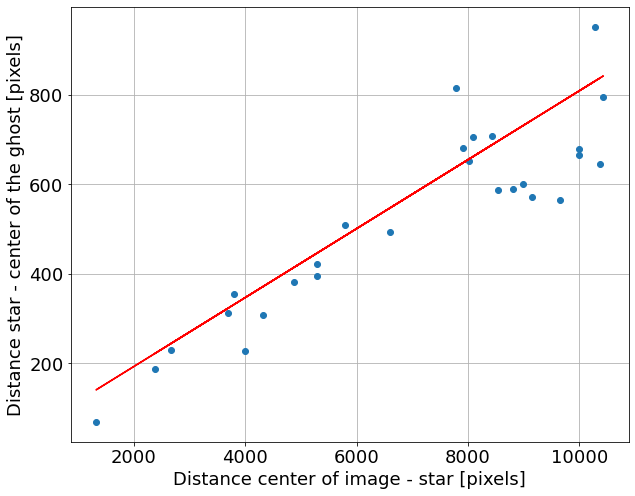

In [7]:
A    = np.vstack([ds, np.ones(len(ds))]).T
m, c = np.linalg.lstsq(A,delta_d,rcond=None)[0]

d_star_ghost = 1.1*m*ds+c
m=1.1*m

plt.figure(figsize=(10,8))
plt.plot(ds,delta_d,'o')
plt.plot(ds,d_star_ghost,'r')
plt.grid()
plt.xlabel('Distance center of image - star [pixels]')
plt.ylabel('Distance star - center of the ghost [pixels]')
print(d_star_ghost.shape)

# Step 2: 
## Verifying that the angle 'star-center of the field' corresponds to the angle 'handmade ghost-center of the field'

In [8]:
ang_s = np.rad2deg(np.arctan(y_s/x_s)) # Theoretical angle between x axes and the star
ang_g = np.rad2deg(np.arctan(y_g/x_g)) # Measured angle between x axes and the star

delta_ang = (ang_g-ang_s)/ang_g        # Relative error between the theoretical and measured angle


Text(0.5, 1.0, 'Relative error between angles')

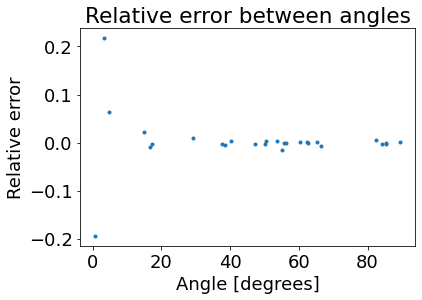

In [9]:
# This plot shows the error between the position of the star and the position of the HANDMADE ghost
plt.plot(ang_g,delta_ang,'.')
plt.xlabel('Angle [degrees]')
plt.ylabel('Relative error')
plt.title('Relative error between angles')

# Step 3: 
## Finding a simple relation for the handmade ghost radius as a function of the star magnitude

[ 9.8594 10.0539  9.965  10.1048  9.2332 10.4421 10.257   7.6894 10.3872
 10.404  10.2098  7.5783  9.3182 10.2796  8.3349  7.8167  9.451   7.8711
  9.0962  8.8403 10.0964 10.3515 10.1927  8.2159 10.2273  8.7698  7.7584] [126.775   146.82    154.545   149.81    784.67499 122.14    140.275
 970.03775 139.73    144.795   141.34    917.98249 825.15999 107.75
 872.84499 936.24635 815.94999 898.31999 831.47999 858.18499 121.325
 128.53    123.315   857.78999 167.555   850.47499 947.66463]


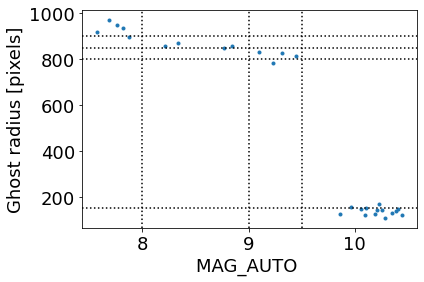

In [10]:
# This plot shows the diameter of the HANDMADE ghosts as a function of the MAG_AUTO
plt.plot(mags,rg,'.')
plt.xlabel('MAG_AUTO ')
plt.ylabel('Ghost radius [pixels]')
plt.axvline(8,ls=':',color='black')
plt.axvline(9,ls=':',color='black')
plt.axvline(9.5,ls=':',color='black')

plt.axhline(150,ls=':',color='black')
plt.axhline(800,ls=':',color='black')
plt.axhline(850,ls=':',color='black')
plt.axhline(900,ls=':',color='black')
print(mags,rg)

# Step 4:

## Generating halo dimensions

Text(0, 0.5, 'Halos radius [pixels]')

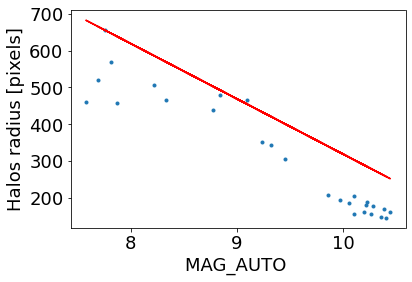

In [11]:
# This plot shows the diameter of the HANDMADE halos as a function of the MAG_AUTO
AA     = np.vstack([mags, np.ones(len(mags))]).T
mm, cc = np.linalg.lstsq(AA,rh,rcond=None)[0]
r_halo = 0.99*mm*mags+1.05*cc
mm=0.99*mm
cc=1.05*cc
plt.plot(mags,rh,'.')
plt.plot(mags,r_halo,'r')

plt.xlabel('MAG_AUTO ')
plt.ylabel('Halos radius [pixels]')

# AUTOMATIC GHOST GENERATOR
### Using only the info contained in the catalog and the relations obtained in the previous 3 plots (distance, angle, radius)

In [12]:
real_fake_mask = np.isin(big_stars[:,0],ignored_stars,invert=False) 
stars_ignored  = big_stars[real_fake_mask] 

id_star_ignored = stars_ignored[:,0]
xs_ignored      = stars_ignored[:,5]
ys_ignored      = stars_ignored[:,6]
mags_ignored    = stars_ignored[:,7]

x_s_ignored = np.abs(xc-xs_ignored)
y_s_ignored = np.abs(yc-ys_ignored)
ds_ignored  = np.sqrt(x_s_ignored**2+y_s_ignored**2)

d_star_ghost_ignored = m*ds_ignored+c

r_halo_ignored = mm*mags_ignored+cc

xs  = np.hstack((xs,xs_ignored))
ys  = np.hstack((ys,ys_ignored))
x_s = np.hstack((x_s,x_s_ignored))
y_s = np.hstack((y_s,y_s_ignored))
d_star_ghost=np.hstack((d_star_ghost,d_star_ghost_ignored))
mags=np.hstack((mags,mags_ignored))
r_halo=np.hstack((r_halo,r_halo_ignored))

print(xs)

[12459.9404 21229.9941 22036.1699 20546.791  11920.6807 22249.0137
 21491.1992 17173.2461  8262.6074 22373.1621 18963.1406 24449.2891
 21955.5039 21688.6445 18781.4941  8388.1602 20083.4023 17150.4844
 13169.082  15293.4131 16731.1504 19033.7461 16019.8281 10147.5068
 16320.0811 24277.8945 15049.3652  7050.1758 25360.1211  6995.4785
  7661.335  25618.6621]


In [13]:
# Defining xy distances star-AUTOMATIC ghost
dx = d_star_ghost*np.cos(np.arctan(y_s/x_s))
dy = d_star_ghost*np.sin(np.arctan(y_s/x_s))

ghost_x = np.empty(len(xs))
ghost_y = np.empty(len(xs))

for i in range(len(xs)):
    if xs[i] > xc and ys[i] > yc:
        ghost_x[i] = xs[i] + dx[i]
        ghost_y[i] = ys[i] + dy[i]
    elif xs[i] < xc and ys[i] > yc:
        ghost_x[i] = xs[i] - dx[i]
        ghost_y[i] = ys[i] + dy[i]
    elif xs[i] < xc and ys[i] < yc:
        ghost_x[i] = xs[i] - dx[i]
        ghost_y[i] = ys[i] - dy[i]
    elif xs[i] > xc and ys[i] < yc:
        ghost_x[i] = xs[i] + dx[i]
        ghost_y[i] = ys[i] - dy[i]

# Defining the radius of the AUTOMATIC ghost
ghost_rad = np.ones(len(ghost_x))
for i in range(len(ghost_x)):
    if mags[i] <= 8:
        ghost_rad[i] = 1000
    elif mags[i] > 8 and mags[i] <= 9:
        ghost_rad[i] = 900
    elif mags[i] > 9 and mags[i] <= 9.5:
        ghost_rad[i] = 850
    elif mags[i] > 9.50:
        ghost_rad[i] = 200
        
        
halos_x = xs
halos_y = ys

halos_rad = r_halo


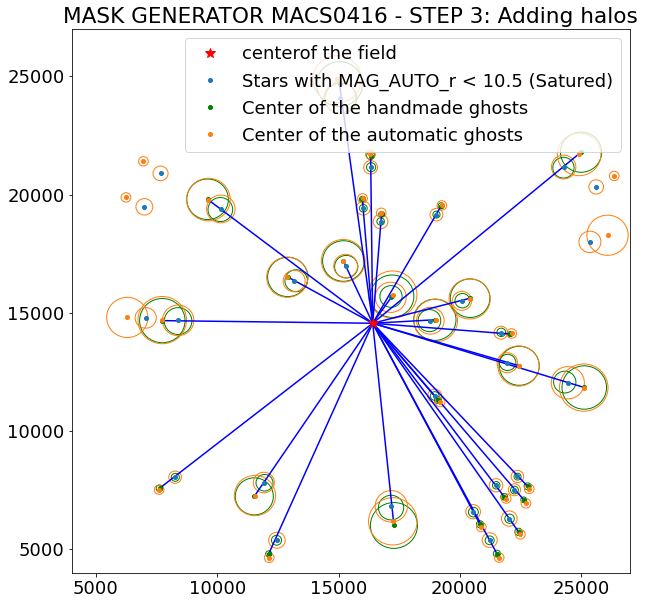

In [14]:
plt.figure(figsize=(10,10))
fig = plt.gcf()
ax  = fig.gca()
for i in range(len(xg)):
    ax.add_artist(patches.Circle((xg[i], yg[i]), rg[i],fill=False, color='g'))                           # Ghosts - HANDMADE
    ax.add_artist(patches.Circle((xh[i], yh[i]), rh[i],fill=False, color='g'))
    plt.plot([xc,xg[i]],[yc,yg[i]],c='b')
for i in range(len(xs)):
    ax.add_artist(patches.Circle((ghost_x[i], ghost_y[i]), ghost_rad[i],fill=False, color='tab:orange')) # Ghosts - AUTOMATIC
    ax.add_artist(patches.Circle((halos_x[i], halos_y[i]), halos_rad[i],fill=False, color='tab:orange')) # Ghosts - AUTOMATIC
    #plt.plot([xc,xs[i]],[yc,ys[i]],c='r')                            # Distance center - stars



    

plt.plot(xc,yc,'*',label='centerof the field',c='r', markersize=10)   # Center of the field
plt.plot(xs,ys,'.',label='Stars with MAG_AUTO_r < 10.5 (Satured)',    markersize=8)    # Stars
plt.plot(xg,yg,'.',label='Center of the handmade ghosts',c='g',    markersize=8)    # Center of the ghosts
plt.plot(ghost_x,ghost_y,'.',label='Center of the automatic ghosts',c='tab:orange',markersize=8)     # Center of the ghosts - HANDMADE!

plt.legend()
plt.xlim(4000,27000)
plt.ylim(4000,27000)

plt.title('MASK GENERATOR MACS0416 - STEP 3: Adding halos')
plt.savefig('Ghost_mask_STEP3.png',dpi=300)
plt.show()

# AUTOMATIC GHOST GENERATOR V2

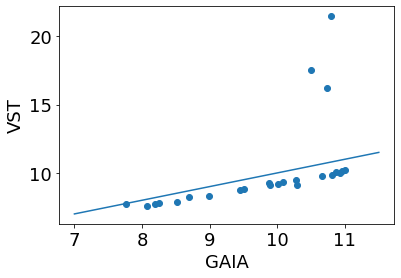

In [15]:
# The goal here is only to use xs_gaia, ys_gaia, mags_gaia

plt.scatter(mags_gaia,mags_ours_gaia)
plt.xlabel('GAIA')
plt.ylabel('VST')
plt.plot(np.arange(7,12,0.5),np.arange(7,12,0.5))

# Generating a fits image with the mask

In [16]:
# Creating a multiline string with the generated ghosts
region = []
for i in range(len(ghost_x)):
    region.append('image;circle('+str(ghost_x[i])+', '+str(ghost_y[i])+', '+str(ghost_rad[i])+')') 
    region.append('image;circle('+str(halos_x[i])+', '+str(halos_y[i])+', '+str(halos_rad[i])+')') 
region = np.array(region)
region = "\n".join(region)

# Using pyregion to create a mask with the ghosts - time consuming!!! -
r = pyregion.parse(region)
mask = r.get_mask(shape=(n1, n2))
mask = mask.astype('uint8')

In [17]:
#  Create a PrimaryHDU object to encapsulate the data:
hdr = fits.Header()
hdr['EQUINOX']  = hdu.header['EQUINOX']
hdr['RADECSYS'] = hdu.header['RADECSYS']
hdr['CTYPE1']   = hdu.header['CTYPE1']
hdr['CUNIT1']   = hdu.header['CUNIT1']
hdr['CRVAL1']   = hdu.header['CRVAL1']
hdr['CRPIX1']   = hdu.header['CRPIX1']
hdr['CD1_1']    = hdu.header['CD1_1']
hdr['CD1_2']    = hdu.header['CD1_2']
hdr['CD2_1']    = hdu.header['CD2_1']
hdr['CD2_2']    = hdu.header['CD2_2']
hdr['CTYPE2']   = hdu.header['CTYPE2']
hdr['CUNIT2']   = hdu.header['CUNIT2']
hdr['CRVAL2']   = hdu.header['CRVAL2']
hdr['CRPIX2']   = hdu.header['CRPIX2']

hdu_output = fits.PrimaryHDU(mask,header=hdr)
hdu_output.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                30000                                                  
NAXIS2  =                30000                                                  
EQUINOX =               2000.0                                                  
RADECSYS= 'ICRS    '                                                            
CTYPE1  = 'RA---TAN'                                                            
CUNIT1  = 'deg     '                                                            
CRVAL1  =               64.125                                                  
CRPIX1  =              15000.5                                                  
CD1_1   =   -5.55555563834E-05                                                  
CD1_2   =                  0

In [ ]:
# Save the PrimaryHDU into a file - 900MB, be careful!
hdu_output.writeto('/users/nestrada/Documents/Game/VST_GAME/M0416/mask_0416.fits',overwrite=True)

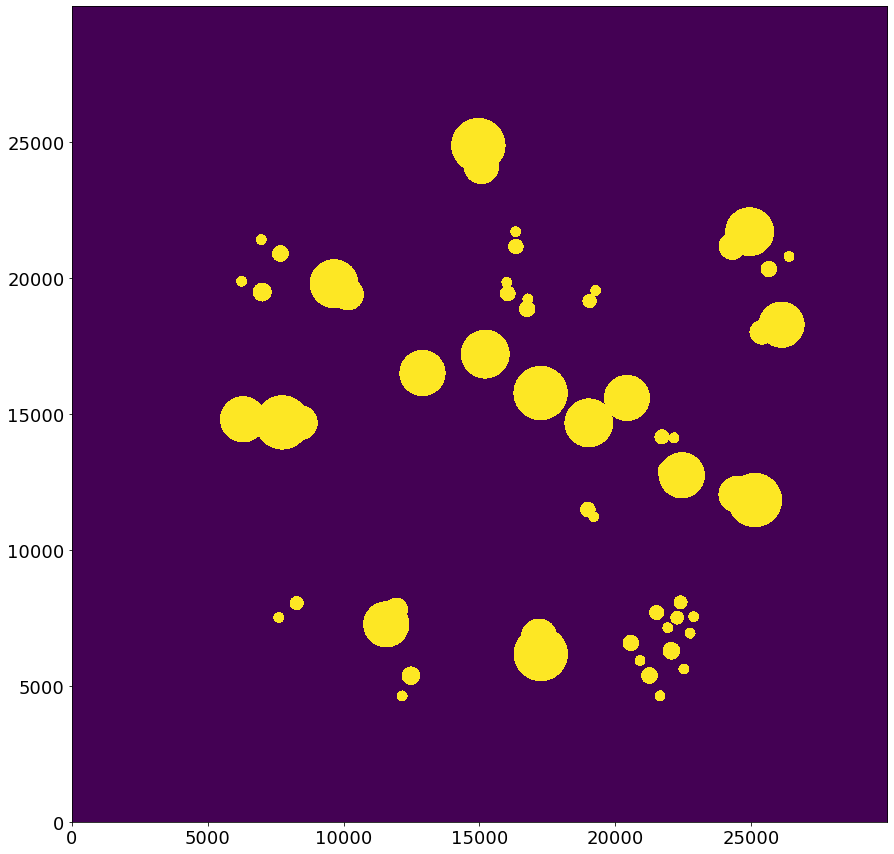

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(mask, origin="lower", interpolation="nearest")
#plt.savefig('Ghost_mask2.png',dpi=100)

# Generating fits with fake stars

In [19]:
image_new           = '/users/nestrada/Documents/Game/VST_GAME/M0416/rband/images/game_macsj0416_r_SDSS_20201229_g2sw.fits'

with fits.open(image_new) as hdulist:
    hdulist.info()
    data = hdulist[0].data
    hdu  = hdulist[0]
    w = wcs.WCS(hdulist[0].header)

n1  = hdu.header['NAXIS1']
n2  = hdu.header['NAXIS2']

# Finding the effective dimensions of the image
for i in range(n1):
    if data[i,:].min() != 0:
        y_min = i 
        break
for i in range(y_min,n1):
    if data[i,:].min() == 0:
        y_max = i 
        break
for i in range(n1):
    if data[:,i].min() != 0:
        x_min = i 
        break
for i in range(x_min,n1):
    if data[:,i].min() == 0:
        x_max = i 
        break
print(x_min, y_min)
print(x_max, y_max)

Filename: /users/nestrada/Documents/Game/VST_GAME/M0416/rband/images/game_macsj0416_r_SDSS_20201229_g2sw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     447   (24000, 24000)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


3966 1610
22848 21507


In [39]:
x_fake = np.random.randint(x_min,x_max,size=10000)
y_fake = np.random.randint(y_min,y_max,size=10000)

data_fake = np.zeros((n1,n2))

for i in range(len(x_fake)):
    for j in range(20):
        data_fake[x_fake[i-j],y_fake[i-j]]=3


"""# Creating a multiline string with the generated ghosts
region_fake = []
for i in range(len(x_fake)):
    region_fake.append('image;circle('+str(x_fake[i])+', '+str(y_fake[i])+', '+str(10)+')') 
    
region_fake = np.array(region_fake)
region_fake = "\n".join(region_fake)

# Using pyregion to create a mask with the ghosts - time consuming!!! -
r_fake = pyregion.parse(region_fake)
mask_fake = r_fake.get_mask(shape=(n1, n2))
mask_fake = mask_fake.astype('uint8')"""

'# Creating a multiline string with the generated ghosts\nregion_fake = []\nfor i in range(len(x_fake)):\n    region_fake.append(\'image;circle(\'+str(x_fake[i])+\', \'+str(y_fake[i])+\', \'+str(10)+\')\') \n    \nregion_fake = np.array(region_fake)\nregion_fake = "\n".join(region_fake)\n\n# Using pyregion to create a mask with the ghosts - time consuming!!! -\nr_fake = pyregion.parse(region_fake)\nmask_fake = r_fake.get_mask(shape=(n1, n2))\nmask_fake = mask_fake.astype(\'uint8\')'

In [40]:
#  Create a PrimaryHDU object to encapsulate the data:
hdr_fake = fits.Header()
hdr_fake['EQUINOX']  = hdu.header['EQUINOX']
hdr_fake['RADECSYS'] = hdu.header['RADECSYS']
hdr_fake['CTYPE1']   = hdu.header['CTYPE1']
hdr_fake['CUNIT1']   = hdu.header['CUNIT1']
hdr_fake['CRVAL1']   = hdu.header['CRVAL1']
hdr_fake['CRPIX1']   = hdu.header['CRPIX1']
hdr_fake['CD1_1']    = hdu.header['CD1_1']
hdr_fake['CD1_2']    = hdu.header['CD1_2']
hdr_fake['CD2_1']    = hdu.header['CD2_1']
hdr_fake['CD2_2']    = hdu.header['CD2_2']
hdr_fake['CTYPE2']   = hdu.header['CTYPE2']
hdr_fake['CUNIT2']   = hdu.header['CUNIT2']
hdr_fake['CRVAL2']   = hdu.header['CRVAL2']
hdr_fake['CRPIX2']   = hdu.header['CRPIX2']

hdu_output_fake = fits.PrimaryHDU(data_fake,header=hdr_fake)
hdu_output_fake.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                24000                                                  
NAXIS2  =                24000                                                  
EQUINOX =               2000.0                                                  
RADECSYS= 'ICRS    '                                                            
CTYPE1  = 'RA---TAN'                                                            
CUNIT1  = 'deg     '                                                            
CRVAL1  =               64.125                                                  
CRPIX1  =              12000.5                                                  
CD1_1   =   -5.55555563834E-05                                                  
CD1_2   =                  0

In [41]:
# Save the PrimaryHDU into a file - 4.6GB, be careful!
hdu_output_fake.writeto('/users/nestrada/Documents/Game/VST_GAME/M0416/fake_stars.fits',overwrite=True)

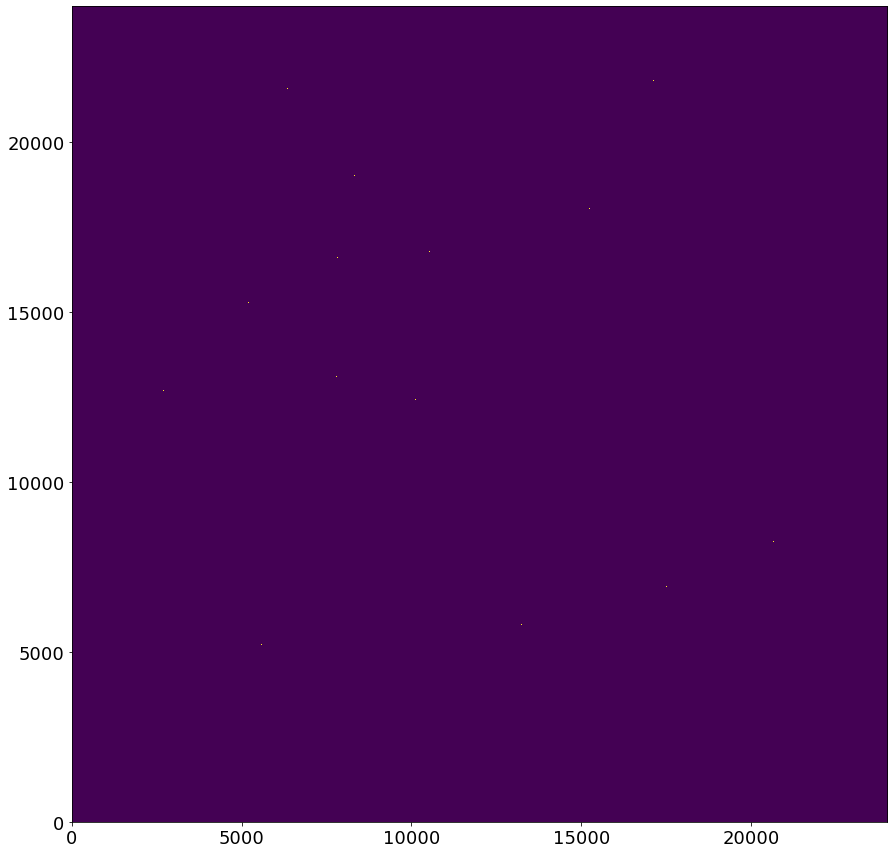

In [36]:
plt.figure(figsize=(15,15))
plt.imshow(data_fake, origin="lower", interpolation="nearest")

In [43]:
import pandas as pd
fake_fluxes_g   = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/SExtractor/fake_fluxes_g.cat",sep='\s+',skiprows=71,header=None)


4897
26.96747380028587 2.114452446531673
12.406125859533418 293.36194966358863


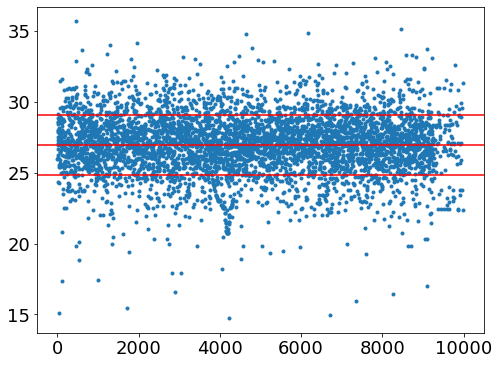

In [73]:
xxx = fake_fluxes_g[14][fake_fluxes_g[14]<50]
fluxxx = 10**((25.-xxx)/2.5)
print(len(xxx))
print(np.mean(xxx),np.std(xxx))
print(np.mean(fluxxx),np.std(fluxxx))

plt.figure(figsize=(8,6))
plt.plot(xxx,'.')
plt.axhline(np.mean(xxx),c='r')
plt.axhline(np.mean(xxx)+np.std(xxx),c='r')
plt.axhline(np.mean(xxx)-np.std(xxx),c='r')

# Appendix - catalog parameters

This cell prints the header of the catalog used in this notebook

In [ ]:
# These are the name of the colums in our SExtractor catalogue
_="""header      = np.array(['ID','RA','DEC','RA_PEAK','DEC_PEAK','X','Y','MAG_AUTO','MAGERR_AUTO','KRON_RADIUS','MU_MAX','ISOAREA','MAG_ISO','MAGERR_ISO','MAG_AP1','MAG_AP2','MAG_AP3','MAG_AP4' ,  'MAG_AP5'  , 'MAG_AP6'  , 'MAG_AP7' ,  'MAG_AP8' ,  'MAG_AP_3FWHM'  , 'MAG_AP_8FWHM' ,  'MAGERR_AP1'  , 'MAGERR_AP2'  , 'MAGERR_AP3'  , 'MAGERR_AP4'  , 'MAGERR_AP5'  , 'MAGERR_AP6',   'MAGERR_AP7' ,  'MAGERR_AP5' ,  'MAGERR_AP_3FWHM'  , 'MAGERR_AP_8FWHM' ,  'FLUX_RADIUS_50' ,  'FLUX_RADIUS_90' ,  'FLAGS' ,  'CLASS_STAR'  , 'FWHM_IMAGE' ,  'BACKGROUND'  ,  'A_IMAGE'  , 'B_IMAGE' ,  'THETA_IMAGE'  , 'MAG_GROWTH_1'  , 'MAG_GROWTH_2' ,  'MAG_GROWTH_3'  , 'MAG_GROWTH_4'  , 'MAG_GROWTH_5'  , 'MAG_GROWTH_6',   'MAG_GROWTH_7' ,  'MAG_GROWTH_8' ,  'MAG_GROWTH_9'  , 'MAG_GROWTH_10' ,  'MAG_GROWTH_11' ,  'MAG_GROWTH_12'  , 'MAG_GROWTH_13'  , 'MAG_GROWTH_14' ,  'MAG_GROWTH_15'  , 'MAG_GROWTH_16' ,  'MAG_GROWTH_17' ,  'MAG_GROWTH_18'  , 'MAG_GROWTH_19' ,  'MAG_GROWTH_20'  , 'MAG_GROWTHSTEP'  , 'MAG_PSF' ,  'MAGERR_PSF' ,  'FWHMPSF_IMAGE',   'FLAGS_MODEL'  , 'MAG_MODEL' ,  'MAGERR_MODEL' ,  'MU_MAX_MODEL'  , 'MU_EFF_MODEL' ,  'XMODEL_IMAGE'  , 'YMODEL_IMAGE' ,  'AMODEL_IMAGE' ,  'BMODEL_IMAGE'  , 'THETAMODEL_IMAGE' ,  'THETAMODEL_SKY',   'SPREAD_MODEL' ,  'SPREADERR_MODEL' ,  'MAG_POINTSOURCE' ,  'MAGERR_POINTSOURCE'  , 'MAG_SPHEROID' ,  'MAGERR_SPHEROID'  , 'MU_MAX_SPHEROID' ,  'MU_EFF_SPHEROID' ,  'SPHEROID_REFF_IMAGE' ,  'SPHEROID_REFFERR_IMAGE'  , 'SPHEROID_ASPECT_IMAGE' ,  'SPHEROID_ASPECTERR_IMA' ,  'SPHEROID_SERSICN'  , 'SPHEROID_SERSICNERR' ,  'MAG_DISK' ,  'MAGERR_DISK'  , 'MU_MAX_DISK' ,  'MU_EFF_DISK' ,  'DISK_SCALE_IMAGE'  , 'DISK_SCALEERR_IMAGE' ,  'DISK_ASPECT_IMAGE'  , 'DISK_ASPECTERR_IMAGE' ,  'MAG_PETRO'  , 'MAGERR_PETRO'  , 'PETRO_RADIUS' ,  'FLUX_AUTO',    'FLUXERR_AUTO' ,  'FLUX_ISO'  ,   'FLUXERR_ISO' ,  'FLUX_MODEL' ,  'FLUXERR_MODEL'])
for i in range(len(header)):
    print(i,header[i])"""

# Appendix 2 - printing catalogue

In [ ]:
# This cell exports the stars catalogue (without the fake detections)
_="""num_points, num_params = stars.shape
with open('M0416_rband_BIG_BIGSTARS_CLEAN.cat','w') as n:
    for i in range(num_points):
        for j in range(num_params):
            print(stars[i,j],end=" ",file=n)
        print(stars[i,-1],file=n)"""